# Triangle Rasterization

## Import

In [1]:
import numpy as np
import copy
import math 
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import  rcParams
import cv2

eps = 1e-6

## Camera Transformation

ÁªôÂÆö‰∏Ä‰∏™Áõ∏Êú∫‰ΩçÁΩÆ $\mathbf{eye}$Ôºå‰∏Ä‰∏™ËßÇÂØüÁÇπ $\mathbf{center}$Ôºå‰∏Ä‰∏™‰∏äÊñπÂêë $\mathbf{up}$ÔºåÂèØ‰ª•Â¶Ç‰∏ãÊ±ÇÂá∫Áõ∏Êú∫ÂùêÊ†á‰∏ãÁöÑ‰∏â‰∏™Âè≥ÊâãÁ≥ªÊ≠£‰∫§Âçï‰ΩçÂü∫Â∫ïÔºöÔºàÊ≥®ÊÑèËøôÈáåÁõ∏Êú∫ÊúùÂêë $\mathbf{z}_{\text{cam}}$ ÁöÑË¥üÊñπÂêëÔºâ

$$
\begin{aligned}
\mathbf{z}_{\text{cam}} &= \frac{\mathbf{eye}-\mathbf{center}}{\left \| \mathbf{eye}-\mathbf{center} \right \| }  \\
\mathbf{x}_{\text{cam}} &= \frac{\mathbf{up} \times \mathbf{z}_{\text{cam} }}{\left \| \mathbf{up} \times \mathbf{z}_{\text{cam}} \right \| } \\ 
\mathbf{y}_{\text{cam}} &= \mathbf{z}_{\text{cam}} \times \mathbf{x}_{\text{cam}}
\end{aligned}
$$

‰∫éÊòØÂèØ‰ª•ÊûÑÂª∫Â¶Ç‰∏ã Camera MatrixÔºö

$$
M_{\text{cam} } =
\begin{bmatrix}
\mathbf{x}_{\text{cam}} &\mathbf{y}_{\text{cam}}  &\mathbf{z}_{\text{cam}} & \mathbf{eye}\\
0 &0  &0  &1
\end{bmatrix}
$$

ÂØπ‰∫é $ M_{\text{cam}} $ÔºåÊàë‰ª¨ÊúâÔºö
$$
\begin{aligned}
\mathbf{p}_{\text{world}} = M_{\text{cam}} \ \mathbf{p}_{\text{cam}} \\
\mathbf{p}_{\text{cam}} = M_{\text{cam}}^{-1} \ \mathbf{p}_{\text{world}}
\end{aligned}
$$
ÂÖ∂‰∏≠ $\mathbf{p}_{\text{world}}$ Âíå $\mathbf{p}_{\text{cam}}$ ÂàÜÂà´Ë°®Á§∫‰∏ñÁïåÂùêÊ†áÁ≥ªÂíåÁõ∏Êú∫ÂùêÊ†áÁ≥ª‰∏ãÁöÑÁÇπÔºå‰ΩøÁî®ÈΩêÊ¨°ÂùêÊ†áË°®Á§∫„ÄÇ

In [2]:
def LookAt(eye, center, up):
    """
    ÊûÑÂª∫Áõ∏Êú∫ÁöÑËßÜÂõæÁü©Èòµ M_cam^-1ÔºåÂÖ∂‰∏≠
    eye Ë°®Á§∫Áõ∏Êú∫Âú®‰∏ñÁïåÂùêÊ†áÁ≥ªÁöÑ‰ΩçÁΩÆÔºå
    center Ë°®Á§∫Áõ∏Êú∫ÈïúÂ§¥ÂØπÂáÜÁöÑÁâ©‰ΩìÂú®‰∏ñÁïåÂùêÊ†áÁ≥ªÁöÑ‰ΩçÁΩÆÔºå
    up Ë°®Á§∫Áõ∏Êú∫Êúù‰∏äÁöÑÊñπÂêëÂú®‰∏ñÁïåÂùêÊ†áÁ≥ª‰∏≠ÁöÑÊñπÂêë„ÄÇ

    Week03 Lec4 p26
    """
    z = eye - center
    z = z / np.linalg.norm(z)
    x = np.cross(up, z)
    x = x / np.linalg.norm(x)
    y = np.cross(z, x)
    y = y / np.linalg.norm(y)
    cam_mat = np.eye(4)
    cam_mat[:3, 0] = x
    cam_mat[:3, 1] = y
    cam_mat[:3, 2] = z
    cam_mat[:3, 3] = eye
    return np.linalg.inv(cam_mat)

## Projection Transformation

### Orthographic Projection

ÁªôÂÆöÈúÄË¶ÅËøõË°åÊ≠£‰∫§ÊäïÂΩ±ÁöÑËåÉÂõ¥ $[\text{left}, \text{right}] \times [\text{bottom}, \text{top}] \times [\text{near}, \text{far}]$ÔºåÂèØ‰ª•ÊûÑÂª∫Â¶Ç‰∏ã Orthographic Projection MatrixÔºö

$$
\begin{aligned}
M_{\text{ortho}} &= 
\begin{bmatrix}
\frac{2}{\text{right}-\text{left}} &0  &0  &0 \\
0 &\frac{2}{\text{top}-\text{bottom}}  &0  &0 \\
0 &0  &\frac{2}{\text{near}-\text{far}}  &0 \\
0 &0  &0  &1
\end{bmatrix}
\begin{bmatrix}
1 &0  &0  &-\frac{\text{right}+\text{left}}{2} \\
0 &1  &0  &-\frac{\text{top}+\text{bottom}}{2} \\
0 &0  &1  &-\frac{\text{far}+\text{near}}{2} \\
0 &0  &0  &1
\end{bmatrix}\\
&=
\begin{bmatrix}
\frac{2}{\text{right}-\text{left}} &0  &0  &-\frac{\text{right}+\text{left}}{\text{right}-\text{left}} \\
0 &\frac{2}{\text{top}-\text{bottom}}  &0  &-\frac{\text{top}+\text{bottom}}{\text{top}-\text{bottom}} \\
0 &0  &\frac{2}{\text{near}-\text{far}}  &-\frac{\text{far}+\text{near}}{\text{near}-\text{far}} \\
0 &0  &0  &1
\end{bmatrix}
\end{aligned}
$$

Âç≥ÂÖàÂ∞ÜÁõÆÊ†áËåÉÂõ¥‰∏≠ÂøÉÂπ≥ÁßªÂà∞ÂéüÁÇπÔºåÂÜçÁº©ÊîæÂà∞ $[-1, 1]$Ôºå<u>**Ê≥®ÊÑèËøôÈáåÁº©ÊîæÊó∂Â∞Ü $\text{near}$ Áº©ÊîæËá≥ $z=1$ Â∞Ü $\text{far}$ Áº©ÊîæËá≥ $z=-1$**</u>

‰∫éÊòØÁªôÂÆö‰∏Ä‰∏™ÁÇπ $\mathbf{p}_{\text{cam}}$ÔºåÂèØ‰ª•ÂæóÂà∞ÂÖ∂Âú®Áõ∏Êú∫ÂùêÊ†áÁ≥ª‰∏ãÁöÑÊ≠£‰∫§ÊäïÂΩ± $\mathbf{p}_{\text{ortho}}$Ôºö

$$
\mathbf{p}_{\text{ortho}} = M_{\text{ortho}} \ \mathbf{p}_{\text{cam}}
$$

In [3]:
def Ortho(left, right, bottom, top, near, far): #Ê≠£‰∫§ÊäïÂΩ±
    """
    ÊûÑÂª∫Áõ∏Êú∫ÁöÑÊ≠£‰∫§ÊäïÂΩ±Áü©ÈòµÔºå
    Ê≠£‰∫§ÊäïÂΩ±Êó∂ÔºåËßÜÊ§é‰ΩìÊòØ‰∏Ä‰∏™ÈïøÊñπ‰ΩìÔºå
    left Âíå right Ë°®Á§∫ÈïøÊñπ‰ΩìÁöÑÂ∑¶„ÄÅÂè≥Èù¢ÁöÑÂùêÊ†áÂÄºÔºå
    bottom Âíå top Ë°®Á§∫ÈïøÊñπ‰Ωì‰∏ã„ÄÅ‰∏äÈù¢ÁöÑÂùêÊ†áÂÄºÔºå
    near Âíå far Ë°®Á§∫Áõ∏Êú∫Âà∞ÈïøÊñπ‰ΩìÂâç„ÄÅÂêéÈù¢ÁöÑË∑ùÁ¶ª„ÄÇ 

    Week03 Lec4 p33
    """
    mat = [
        [2 / (right - left), 0, 0, -(right + left) / (right - left)],
        [0, 2 / (top - bottom), 0, -(top + bottom) / (top - bottom)],
        [0, 0, 2 / (near - far), -(far + near) / (near - far)],
        [0, 0, 0, 1]
    ]
    mat = np.array(mat)
    return mat

### Perspective Projection

ÁªôÂÆö‰∏Ä‰∏™ËßÜËßí $\text{fov} \ \left ( \text{rad} \right )$ÔºåÂèØ‰ª•Â¶Ç‰∏ãÂú∞ÊûÑÂª∫ Perspective Projection MatrixÔºö

**È¶ñÂÖà**ÔºåÊ†πÊçÆËøëÂπ≥Èù¢Ë∑ùÁ¶ª $\text{near}$ ÂíåËøúÂπ≥Èù¢Ë∑ùÁ¶ª $\text{far}$ÔºåÂèØ‰ª•ÂæóÂà∞Â∞ÜÈÄèËßÜÈî•ÂΩ¢ÂéãÁº©‰∏∫Ê≠£‰∫§ÈÄèËßÜÁöÑÁü©Èòµ $M_{\text{persp} \rightarrow \text{ortho}}$Ôºö

$$
M_{\text{persp} \rightarrow \text{ortho}} = 
\begin{bmatrix}
\text{near} &0  &0  &0 \\
0 &\text{near}  &0  &0 \\
0 &0  &\text{near}+\text{far}  &-\text{near} \cdot \text{far} \\
0 &0  &1  &0
\end{bmatrix}
$$

Ëøô‰∏™Áü©Èòµ‰ΩøÂæóËøëÂπ≥Èù¢ $\text{near}$ ‰∏äÁöÑÁÇπ‰∏çÂèòÔºåËøúÂπ≥Èù¢ $\text{far}$ ‰∏äÁöÑÁÇπÁöÑ $z$ ÂùêÊ†á‰∏çÂèòÔºå‰ΩÜ $x$ Âíå $y$ ÂùêÊ†áÈÉΩË¢´ÂéãÁº©‰∏∫ÂéüÊù•ÁöÑ $\frac{\text{near}}{\text{far}}$ ÂÄç„ÄÇÊé®ÂØºËøáÁ®ãËßÅ Week03 Lec4 ÁöÑ 39-46 È°µ„ÄÇ

**ÁÑ∂Âêé**ÔºåÂÜçÊ†πÊçÆËßÜËßí $\text{fov}$ ÂíåËøë„ÄÅËøúÂπ≥Èù¢Ôºå‰ª•ÂèäËßÜËßíÂÆΩÈ´òÊØî $\text{aspect}$ ÂèØ‰ª•ÂæóÂà∞ÁõÆÊ†áÂå∫Âüü $[\text{left}, \text{right}] \times [\text{bottom}, \text{top}] \times [\text{near}, \text{far}]$Ôºö

$$
\begin{aligned}
\text{bottom} &= -  \left | \text{near} \cdot \tan \frac{\text{fov}}{2} \right | \\
\text{top} &=  \left | \text{near} \cdot \tan \frac{\text{fov}}{2} \right | \\
\text{left} &= \text{near} \cdot \tan \frac{\text{fov}}{2} \cdot \text{aspect}  \\
\text{right} &= - \text{near} \cdot \tan \frac{\text{fov}}{2} \cdot \text{aspect} \\
\end{aligned}
$$

Ê≥®ÊÑèËøôÈáå $\text{left}$ ‰∏∫ $\text{near}$ Áõ∏ÂØπ‰∫éÊëÑÂÉèÊú∫ÂùêÊ†áÁ≥ªÂéüÁÇπÊñπÂêëÁöÑÂ∑¶‰æßÔºåÂÖ∂‰ªñÂêåÁêÜÔºåÊâÄ‰ª•ÈúÄË¶ÅËøõË°åÂ¶Ç‰∏äÁ¨¶Âè∑ÁöÑËÆ°ÁÆó„ÄÇ

**‰πãÂêé**ÔºåÂÜçÈÄöËøáÂâçËø∞ÊñπÊ≥ïÔºåÂæóÂà∞Â∞ÜÁõÆÊ†áÂå∫ÂüüËøõË°åÊ≠£‰∫§ÊäïÂΩ±ÁöÑÁü©Èòµ $M_{\text{ortho}}$„ÄÇ

**ÊúÄÂêé**ÔºåÂèØ‰ª•ÂæóÂà∞ Perspective Projection MatrixÔºö

$$
M_{\text{persp}} = M_{\text{ortho}} \ M_{\text{persp} \rightarrow \text{ortho}}
$$

In [4]:
def get_ortho_params(fov, aspect, near):
    """
    Ê†πÊçÆÁõ∏Êú∫ÁöÑËßÜÈáéËßíÂ∫¶ÂíåËøëË£ÅÂâ™Èù¢ÁöÑË∑ùÁ¶ªËÆ°ÁÆóÁõ∏Êú∫ÁöÑÊ≠£‰∫§ÊäïÂΩ±Áü©ÈòµÁöÑÂèÇÊï∞
    """
    bottom = -abs(near * math.tan(fov / 2))
    top = abs(near * math.tan(fov / 2))
    left = near * math.tan(fov / 2) * aspect
    right = -near * math.tan(fov / 2) * aspect
    return left, right, bottom, top

def Perspective(fov, aspect=1.0, near=-0.1, far=-10.0): # ÈªòËÆ§Áõ∏Êú∫Âêë-zËΩ¥ÊñπÂêëÁúãÔºånearÂíåfar‰∏∫Ë¥üÊï∞
    """
    ÊûÑÂª∫Áõ∏Êú∫ÁöÑÈÄèËßÜÊäïÂΩ±Áü©ÈòµÔºåÂÖ∂‰∏≠
    fov Ë°®Á§∫Áõ∏Êú∫ËßÜÊ§é‰ΩìÁöÑ y ÊñπÂêë‰∏äÁöÑËßÜÈáéËßíÂ∫¶Ôºå
    aspect Ë°®Á§∫ËßÜÊ§é‰ΩìÁöÑÂÆΩÈ´òÊØîÔºåÂç≥
    near Âíå far Ë°®Á§∫ËßÜÊ§é‰ΩìËøë„ÄÅËøúË£ÅÂâ™Èù¢ÁöÑË∑ùÁ¶ª„ÄÇ

    Week03 Lec4 p35
    """
    fov = fov / 180.0 * math.pi
    # M_{persp -> ortho}
    mat = [ 
        [near, 0, 0, 0],
        [0, near, 0, 0],
        [0, 0, near + far, -near * far],
        [0, 0, 1, 0]
    ]
    mat = np.array(mat)
    # M_{persp} = M_{ortho} * M_{persp -> ortho}
    left, right, bottom, top = get_ortho_params(fov, aspect, near)
    mat = Ortho(left, right, bottom, top, near, far) @ mat
    return mat

## Triangle

‰∏âËßíÂΩ¢Á±ª‰∏≠ÔºåÈúÄË¶ÅÂÆûÁé∞‰ª•‰∏ã‰∏§‰∏™ÊñπÊ≥ïÔºö

### rotate_norm

ËøôÈáåË¶ÅÊ±ÇÂÆûÁé∞‰∏Ä‰∏™ÊñπÊ≥ïÔºåÂ∞Ü‰∏âËßíÂΩ¢ $ABC$ ÁªïËøáËá™Ë∫´ÈáçÂøÉÁöÑÊ≥ïÂêëÈáèÊóãËΩ¨ $\theta$ ËßíÂ∫¶„ÄÇ

**È¶ñÂÖà**ÔºåËÆ°ÁÆó‰∏âËßíÂΩ¢ÈáçÂøÉÔºö

$$
\mathbf{center} = \frac{\mathbf{A} + \mathbf{B} + \mathbf{C}}{3}
$$

**ÁÑ∂Âêé**ÔºåËÆ°ÁÆó‰∏âËßíÂΩ¢Ê≥ïÂêëÈáèÔºö

$$
\mathbf{norm} = \left ( \mathbf{B} - \mathbf{A} \right ) \times \left ( \mathbf{C} - \mathbf{A} \right )
$$

**ÊúÄÂêé**ÔºåËÆ°ÁÆóÊóãËΩ¨Áü©ÈòµÔºö

ÊóãËΩ¨Áü©ÈòµÁî±‰∏â‰∏™ÈÉ®ÂàÜÁªÑÊàêÔºöÂ∞Ü‰∏âËßíÂΩ¢ÈáçÂøÉÂπ≥ÁßªÂà∞ÂéüÁÇπ„ÄÅÁªïÊ≥ïÂêëÈáèÊóãËΩ¨ $\theta$ ËßíÂ∫¶„ÄÅÂ∞Ü‰∏âËßíÂΩ¢ÈáçÂøÉÂπ≥ÁßªÂõûÂéüÊù•ÁöÑ‰ΩçÁΩÆ„ÄÇ

$$
\begin{aligned}
M_{\text{center} \rightarrow \text{origin}} &=
\begin{bmatrix}
I &-\mathbf{center} \\
\mathbf{0}  &1
\end{bmatrix} \\ \\

M_{\text{rotate}} &=
cos\theta \begin{bmatrix}  1 & 0 & 0\\  0 & 1 & 0\\  0 & 0 &1 \end{bmatrix} + 
(1-cos\theta)\begin{bmatrix}  k_{x} \\  k_{y} \\ k_{z}  \end{bmatrix}\begin{bmatrix}  k_{x} &  k_{y} &k_{y} \end{bmatrix} + 
sin\theta\begin{bmatrix}  0 &  -k_{z}& k_{y}\\ k_{z}  &0  &-k_{x} \\  -k_{y} & k_{x} &0  \end{bmatrix}\\

M_{\text{rotate}}^{homo} &=
\begin{bmatrix}
M_{\text{rotate}} & \mathbf{0} \\
\mathbf{0} &1 \\
\end{bmatrix} \\ \\

M_{\text{origin} \rightarrow \text{center}} &=
\begin{bmatrix}
I  &\mathbf{center} \\
\mathbf{0}  &1
\end{bmatrix} \\
\end{aligned}
$$

ÂÖ∂‰∏≠ÔºåÁªïÊ≥ïÂêëÈáèÊóãËΩ¨ $\theta$ ËßíÂ∫¶ÁöÑÊóãËΩ¨Áü©Èòµ $M_{\text{rotate}}$ ÈÄöËøá Rodrigues ÂÖ¨ÂºèËÆ°ÁÆóÂæóÂà∞Ôºå$k$ ‰∏∫Âçï‰ΩçÂåñÁöÑÊ≥ïÂêëÈáè $\mathbf{norm}$„ÄÇËØ¶ÁªÜÂèØËßÅ[Áª¥Âü∫ÁôæÁßë](https://zh.wikipedia.org/wiki/%E7%BD%97%E5%BE%B7%E9%87%8C%E6%A0%BC%E6%97%8B%E8%BD%AC%E5%85%AC%E5%BC%8F) or Week2 Lec3 p49„ÄÇ

‰ª£Á†Å‰∏≠ÔºåÁõ¥Êé•‰ΩøÁî®‰∫Ü `cv2.Rodrigues` ÂáΩÊï∞ËÆ°ÁÆóÊóãËΩ¨Áü©ÈòµÔºåËØ•ÂáΩÊï∞Êé•Êî∂‰∏Ä‰∏™‰∏âÁª¥ÂêëÈáèÔºåËØ•ÂêëÈáèÊñπÂêë‰∏∫ÊóãËΩ¨ËΩ¥ÔºåÊóãËΩ¨ÊñπÂêë‰∏∫ËØ•ÂêëÈáèÁöÑÂè≥ÊâãËû∫ÊóãÊñπÂêëÔºåÈïøÂ∫¶‰∏∫ÊóãËΩ¨ËßíÂ∫¶ÔºåËøîÂõû‰∏Ä‰∏™Ê†áÂáÜÊóãËΩ¨Áü©ÈòµÔºåËøôÈáåÊàë‰ª¨ÈúÄË¶ÅÂ∞ÜÂÖ∂ËΩ¨Êç¢‰∏∫ÈΩêÊ¨°ÂùêÊ†á‰∏ãÁöÑÁü©Èòµ„ÄÇ

**ÊúÄÁªà**ÔºåÊàë‰ª¨ÂØπ‰∏âËßíÂΩ¢ÁöÑÈΩêÊ¨°ÂùêÊ†áÁü©ÈòµÊåâÂ∫èÂ∑¶‰πò‰∏äËø∞Áü©ÈòµÂç≥ÂèØÂÆåÊàêÊóãËΩ¨„ÄÇ

### inside

ËøôÈáåË¶ÅÊ±ÇÂÆûÁé∞‰∏Ä‰∏™ÊñπÊ≥ïÔºåÂà§Êñ≠‰∏Ä‰∏™ÁÇπÊòØÂê¶Âú®‰∏âËßíÂΩ¢ÂÜÖÈÉ®Ôºö

ÊúâÂ§öÁßçÊñπÊ≥ïËÉΩÂ§üÂÆûÁé∞Ëøô‰∏™Êìç‰ΩúÔºåÈÉΩÊØîËæÉÁõ¥ËßÇÊòìÊáÇÔºåËøôÈáå‰∏çÂÜç‰ΩúÂÖ¨ÂºèÊé®ÂØºÔºö
- <u>Ëã•Â∑≤Áü•ÁÇπÂú®‰∏âËßíÂΩ¢Âπ≥Èù¢ÂÜÖÔºåÂàôÂèØÁî®‰∫åÁª¥Âπ≥Èù¢‰∏äÁöÑÈáçÂøÉÂùêÊ†áË°®Á§∫ÂèëÂ∞ÜÁÇπPÁî®‰∏âËßíÂΩ¢‰∏§ËæπÁöÑÁ∫øÊÄßÁªÑÂêàË°®Á§∫Âá∫Êù•ÔºåÂπ∂ÈÄöËøáÁ∫øÊÄßË°®Á§∫Á≥ªÊï∞Âà§Êñ≠Âç≥ÂèØÔºà‰ª£Á†Å‰∏≠ÊúÄÁªà‰ΩøÁî®ÁöÑÊñπÊ≥ïÔºåÈÄüÂ∫¶ÊúÄÂø´ÔºåÂõ†‰∏∫Êàë‰ª¨ÊòØÂú®ÊäïÂΩ±ÂèòÊç¢ÂêéÁöÑ‰∫åÁª¥Âπ≥Èù¢‰∏≠ËøõË°åÂà§Êñ≠ÔºâÔºåÂπ∂‰∏îËøòÂèØ‰ª•Â∞ÜÈáçÂøÉÂùêÊ†áËøîÂõûÁî®‰∫éÂêéÈù¢ÁöÑ**Ê∑±Â∫¶ÊµãËØï**‰∏é**È¢úËâ≤Â∑ÆÂÄº**ÁöÑËÆ°ÁÆó</u>
- ÂΩìÁÇπ‰∏ç‰∏ÄÂÆöÂú®‰∏âËßíÂΩ¢Âπ≥Èù¢ÂÜÖÊó∂
  - ÂèØ‰ΩøÁî®‰∏âÁª¥Á©∫Èó¥ÁöÑÈáçÂøÉÂùêÊ†áÊ≥ïË°®Á§∫Âá∫PÔºåÁÑ∂ÂêéÈÄöËøáÁ∫øÊÄßË°®Á§∫Á≥ªÊï∞ÊòØÂê¶Âíå‰∏∫1‰∏îÂùá‰∏∫Ê≠£Âà§Êñ≠
  - Êàñ‰ΩøÁî®ÁÇπ‰∏é‰∏âËßíÂΩ¢È°∂ÁÇπÁöÑÂêëÈáè‰∏éËæπÂêëÈáè‰ΩúÂèâÁßØÔºåÂπ∂Âà§Êñ≠‰∏â‰∏™ÂèâÁßØÊòØÂê¶ÂêåÂêëÂêåÂè∑Âç≥ÂèØÔºà‰ª£Á†Å‰∏≠Ê≥®ÈáäÈÉ®ÂàÜÊúâÂÆûÁé∞Ôºå‰ΩÜÈÄüÂ∫¶ËæÉÊÖ¢Ôºâ

### Triangle Class:

In [5]:
class Triangle(object): 
    
    def __init__(self):
        self.vertices = np.zeros((3, 3))
        self.normals = np.eye(3)
        self.colors = np.zeros((3,3))
        self.tex_coords = np.zeros((3, 2))
    
    def setVertex(self, ind, x, y, z):
        self.vertices[ind][0] = x
        self.vertices[ind][1] = y
        self.vertices[ind][2] = z
    
    def setColor(self, ind, r, g, b):
        self.colors[ind][0] = r
        self.colors[ind][1] = g
        self.colors[ind][2] = b
    
    def setNormal(self, ind, nx, ny, nz): # x y x
        self.normals[ind][0] = nx
        self.normals[ind][1] = ny
        self.normals[ind][2] = nz
    
    def setTexCoord(self, ind, tx, ty):
        self.tex_coords[ind][0] = tx
        self.tex_coords[ind][1] = ty

    def rotate_norm(self, theta):
        """
        ÈÄöËøá‰∏âËßíÂΩ¢‰∏â‰∏™È°∂ÁÇπËÆ°ÁÆóÂÖ∂Ê≥ïÁ∫øÊñπÂêëÔºå
        ÁÑ∂ÂêéËÆ°ÁÆó‰∏â‰∏™È°∂ÁÇπÁªï‰∏âËßíÂΩ¢‰∏≠ÂøÉÁÇπÔºåËΩ¥‰∏∫Ê≥ïÁ∫øÊóãËΩ¨ theta Â∫¶ÂêéÁöÑÊñ∞‰ΩçÁΩÆÔºå
        Âπ∂Êõ¥Êñ∞self.vertices
        """
        A = self.vertices[0]
        B = self.vertices[1]
        C = self.vertices[2]
        norm = np.cross(B-A, C-A)
        norm = norm / np.linalg.norm(norm)

        center = (A + B + C) / 3.0

        # ÊóãËΩ¨Áü©ÈòµÔºåÁªïnormËΩ¥ÊóãËΩ¨theaÂ∫¶Ôºå‰ΩøÁî®RodriguesÂÖ¨ÂºèËÆ°ÁÆó
        mat1 = np.eye(4)
        rot_mat = cv2.Rodrigues(norm * theta)[0]
        mat1[:3,:3] = rot_mat
        # Âπ≥ÁßªÔºåÂ∞Ü‰∏âËßíÂΩ¢‰∏≠ÂøÉÁßªÂä®Âà∞ÂéüÁÇπ
        mat2 = np.eye(4)
        mat2[:3,3] = -center
        # Âπ≥ÁßªÔºåÂ∞Ü‰∏âËßíÂΩ¢‰∏≠ÂøÉÁßªÂä®ÂõûÂéª
        mat3 = np.eye(4)
        mat3[:3,3] = center
        # ÊóãËΩ¨
        self.vertices = ((mat3 @ mat1 @ mat2 @ self.to_homogeneous_coordinates().T).T)[:,:3]

    
    def rotate_mat(self, mat): #mat 3x3
        self.vertices = (mat @ self.vertices.T).T
    
    def get_barycentric_coord(self, x, y, z):
        A = self.vertices[0]
        B = self.vertices[1]
        C = self.vertices[2]
        P = np.array([x, y, z])

        # ÈáçÂøÉÂùêÊ†áÊ≥ïÔºö Âø´
        # 2D
        AB = B - A
        AC = C - A
        AP = P - A
        # ÈáçÂøÉÂùêÊ†á AP = u * A + v * B + w * C
        v = (np.dot(AP, AB) * np.dot(AC, AC) - np.dot(AP, AC) * np.dot(AB, AC)) / (np.dot(AB, AB) * np.dot(AC, AC) - np.dot(AB, AC) * np.dot(AB, AC))
        w = (np.dot(AP, AC) * np.dot(AB, AB) - np.dot(AP, AB) * np.dot(AB, AC)) / (np.dot(AB, AB) * np.dot(AC, AC) - np.dot(AB, AC) * np.dot(AB, AC))
        u = 1 - v - w
        return u, v, w

        # or 3D
        # ÈáçÂøÉÂùêÊ†á AP = u * A + v * B + w * C

    
    def inside(self, x, y, z):
        """
        Âà§Êñ≠ÁÇπ(x,y,z)ÊòØÂê¶Âú®‰∏âËßíÂΩ¢Èáå
        """
        u, v, w = self.get_barycentric_coord(x, y, z)
        if u >= -eps and v >= -eps and w >= -eps:
            return True, u, v, w
        else:
            return False, u, v, w
        
        # Âèâ‰πòÂêåÂêëÊ≥ïÔºö ÊÖ¢
        # AB = B - A
        # BC = C - B
        # CA = A - C
        # AP = P - A
        # BP = P - B
        # CP = P - C
        # c1 = np.cross(AB, AP)
        # c2 = np.cross(BC, BP)
        # c3 = np.cross(CA, CP)
        # if np.dot(c1, c2) >= 0 and np.dot(c2, c3) >= 0 and np.dot(c3, c1) >= 0: # ÂáÜÁ°ÆÊù•ËØ¥ÔºåËøôÈáåËøòÈúÄË¶ÅÂà§Êñ≠Âπ≥Ë°å
        #     return True
        # else:
        #     return False
        
    def to_homogeneous_coordinates(self):
        return np.hstack((self.vertices, np.ones((3, 1))))

## Rasterization

ÂÖâÊ†ÖÂåñÈÉ®ÂàÜÔºå‰∏ªË¶ÅË¶ÅÊ±ÇÊàë‰ª¨Ê∏≤ÊüìÊó∂ÂØπ‰∏âËßíÂΩ¢È¢úËâ≤ËøõË°åÈáçÂøÉÂùêÊ†áÊèíÂÄºÔºåÂπ∂ÂÆûÁé∞Ê∑±Â∫¶ÊµãËØï„ÄÇ

È¶ñÂÖàÔºåÊàë‰ª¨Â∑≤ÁªèÂú®‰∏âËßíÂΩ¢ÈÉ®ÂàÜÂÆûÁé∞‰∫Ü‰∫åÁª¥Âπ≥Èù¢‰∏äÁöÑÈáçÂøÉÂùêÊ†áËÆ°ÁÆóÔºå‰ΩÜÂú®ÂÖâÊ†ÖÂåñÊó∂ÔºåÊàë‰ª¨Ëé∑ÂæóÁöÑÊòØÂ∑≤ÁªèÂèòÊç¢Ëá≥Â±èÂπïÁ©∫Èó¥ÁöÑ‰∏âËßíÂΩ¢ÔºåÁõ¥Êé•‰ΩøÁî®Ëøô‰∏™‰∏âËßíÂΩ¢ËøõË°åÈáçÂøÉÂùêÊ†áÁöÑËÆ°ÁÆóÂπ∂ËøõË°åÊèíÂÄºÊòØ‰∏çÊ≠£Á°ÆÁöÑÔºå‰æãÂ¶Ç‰ªéÁΩë‰∏äÂØªÊâæÁöÑ‰∏ãÂõæÔºö

![ÈÄèËßÜÁü´Ê≠£ÊèíÂÄº](https://pic1.zhimg.com/80/v2-870848b15ece69ce4801c187ab39df20_1440w.webp)

Âõæ‰∏≠BC‰∏§ÁÇπÁöÑ‚Äú‰∏≠ÁÇπ‚ÄùÂ∫îËØ•ÊòØÊâÄÁîªÁ∫¢ÁªøËìùÁ∫øÁöÑ‰∫§ÁÇπÔºåËÄåÂú®Á¨¨‰∫åÂπÖÂõæ‰∏≠ÁöÑÂ±èÂπïÁ©∫Èó¥ÂÜÖÂèñ‰∏≠ÁÇπÂàô‰ºöÂÅèÁ¶ªÔºåËøôÊòØÈÄèËßÜÂèòÊç¢ÂØºËá¥ÁöÑÈóÆÈ¢ò„ÄÇËß£ÂÜ≥‰∏äËø∞ÈóÆÈ¢òÁöÑÊö¥ÂäõÈÄîÂæÑÊòØËøõË°åÈÄÜÂèòÊç¢Ëé∑ÂèñÊ∏≤ÊüìÁöÑÁõÆÊ†áÁÇπÂú®ÂéüÁõ∏Êú∫ÂùêÊ†áÁ≥ª‰∏ãÁöÑ‰ΩçÁΩÆÔºå‰ΩÜËøôÊ†∑ÂÅöÊòæÁÑ∂ÊàêÊú¨ËøáÈ´ò„ÄÇÊâÄ‰ª•Êàë‰ª¨ÈúÄË¶ÅÂØπÂÖ∂ËøõË°åÈÄèËßÜÂèòÊç¢Áü´Ê≠£ÊèíÂÄºÔºåÊù•ÈÄöËøáÂèòÊç¢ÂêéÁöÑ‰∏âËßíÂΩ¢ÁöÑÈáçÂøÉÂùêÊ†áÔºåÂíå‰∏â‰∏™ËßíÁöÑÂ±ûÊÄßÂÄºÔºåÊù•Ëé∑ÂæóÂéüÁ©∫Èó¥ÂÜÖ‰∏âËßíÂΩ¢ÁöÑÊèíÂÄºÁªìÊûú„ÄÇ

### ÈÄèËßÜÂèòÊç¢Áü´Ê≠£ÊèíÂÄº

‰∏ãÈù¢‰∏ªË¶Å‰ºöÁªôÂá∫<u>***ÈÄèËßÜÂèòÊç¢Áü´Ê≠£ÊèíÂÄº***</u>ÁöÑÊé®ÂØºÔºö

</br></br>

È¶ñÂÖàÊàë‰ª¨ËÆ°ÁÆóÂæÖÊ∏≤ÊüìÁÇπÂú®ÂéüÂßãÁõ∏Êú∫ÂùêÊ†áÁ≥ª‰∏ãÁöÑ Z ÂùêÊ†áÔºå‰ª•ÂÆåÊàê<u>**Ê∑±Â∫¶ÊµãËØï**</u>ÔºåÂπ∂ËæÖÂä©ÂÖ∂‰ªñÂ±ûÊÄßÁöÑÈáçÂøÉÂùêÊ†áÂ∑ÆÂÄºÂíåÈÄèËßÜÂèòÊç¢Áü´Ê≠£ÊèíÂÄºÔºö

Êàë‰ª¨ËÆæÁõ∏Êú∫ÂùêÊ†áÁ≥ª‰∏ã‰∏âËßíÂΩ¢‰∏â‰∏™ÁÇπÂàÜÂà´‰∏∫Ôºö$A, B, C$ÔºåÂÖ∂ÂØπÂ∫îÊäïÂΩ±ÂèòÊç¢ÂêéÁöÑÂ±èÂπïÁ©∫Èó¥ÂÜÖ‰∏âËßíÂΩ¢ÁöÑ‰∏â‰∏™ÁÇπÂàÜÂà´‰∏∫Ôºö$A', B', C'$Ôºå

ÂÜçËÆæÂæÖÊ∏≤ÊüìÁöÑÂ±èÂπïÁ©∫Èó¥ÂÜÖÁöÑÁõÆÊ†áÁÇπ‰∏∫ $P'$ÔºåÂÖ∂Â±èÂπïÁ©∫Èó¥ÂÜÖ‰∏âËßíÂΩ¢ÁöÑÈáçÂøÉÂùêÊ†á‰∏∫ $\alpha', \beta', \gamma'$Ôºå
ÂÖ∂ÂØπÂ∫îÁöÑÁõ∏Êú∫ÂùêÊ†áÁ≥ª‰∏≠ÁöÑÂéüÂßãÁÇπ‰∏∫ $P$ÔºåÂÖ∂ÈáçÂøÉÂùêÊ†á‰∏∫ $\alpha, \beta, \gamma$

Áî±‰∏âËßíÂΩ¢ÈáçÂøÉÊèíÂÄºÊàë‰ª¨ÂèØÂæóÂà∞Ôºö

$$
\begin{aligned}
Z  &= \alpha Z_A+\beta Z_B + \gamma Z_C \\
Z' &= \alpha' Z_{A'}+\beta' Z_{B'} + \gamma' Z_{C'} \\
\end{aligned}
$$

ÂèàÂõ†‰∏∫ $ \alpha' +\beta' + \gamma' =1 $Ôºå‰∫éÊòØÂèòÂΩ¢ÂæóÂà∞Ôºö

$$
\begin{aligned}
1 &= \alpha' +\beta' + \gamma'  \\
 \frac{Z}{Z} &= \frac{Z_A}{Z_A}\alpha' +\frac{Z_B}{Z_B}\beta' + \frac{Z_C}{Z_C}\gamma'  \\
 Z &= (\frac{Z}{Z_A}\alpha')Z_A +(\frac{Z}{Z_B}\beta')Z_B + (\frac{Z}{Z_C}\gamma')Z_C  \\
\end{aligned}
$$

ÁªìÂêà‰∏äÂºèÔºåÊàë‰ª¨ÂèØ‰ª•ÂæóÂá∫Ôºö

$$
(\frac{Z}{Z_A}\alpha') = \alphaÔºå(\frac{Z}{Z_B}\beta')=\betaÔºå(\frac{Z}{Z_C}\gamma')=\gamma  \\
$$

ÊâÄ‰ª•

$$
1 = \frac{Z}{Z_A}\alpha'+\frac{Z}{Z_B}\beta'+\frac{Z}{Z_C}\gamma' \\
$$

‰∫éÊòØ

$$
\frac{1}{Z} = \frac{1}{Z_A}\alpha'+\frac{1}{Z_B}\beta'+\frac{1}{Z_C}\gamma' \\
$$

Ëá≥Ê≠§ÔºåÊàë‰ª¨ÂèØ‰ª•ËÆ°ÁÆóÂá∫ $P$ Âú®Áõ∏Êú∫ÂùêÊ†áÁ≥ª‰∏ãÁöÑ Z ÂùêÊ†áÔºå‰ª•ÂÆåÊàêÊ∑±Â∫¶ÊµãËØï„ÄÇ

‰ΩÜÁªÜÂøÉÁÇπÂèØ‰ª•ÂèëÁé∞ÔºåËøôÈáåÊâÄÊúâ $\mathbf{z}$ ÂùêÊ†áÂùáÂú®ÂàÜÊØçÔºåÊâÄ‰ª•ÂΩì‰∏âËßíÂΩ¢Êúâ‰∏Ä‰∏™È°∂ÁÇπ‰ª•‰∏ä‰Ωç‰∫éÁõ∏Êú∫Âπ≥Èù¢Êó∂Ôºå‰ºöÂá∫Áé∞Èô§Èõ∂ÈîôËØØÔºåËøôÊòØ‰∏Ä‰∏™ÂæÖËß£ÂÜ≥ÁöÑÈóÆÈ¢òÔºå‰ΩÜÂè™Ë¶Å‰øùËØÅ‰∏âËßíÂΩ¢Âú®ÊëÑÂÉèÊú∫ÂâçÊñπÂ∞±‰∏ç‰ºöÂá∫Áé∞Ëøô‰∏™ÈîôËØØ„ÄÇ

</br></br>

ÁΩÆ‰∫é<u>**ÂÖ∂‰ªñÂ±ûÊÄßÁöÑÂ∑ÆÂÄº**</u>ÔºåÁêÜËÆ∫‰∏äÂèØ‰ª•Áõ¥Êé•ÊõøÊç¢ $\mathbf{z}$Ôºå‰ΩÜÊòØÁî±‰∫éÈô§Èõ∂ÈóÆÈ¢òÁöÑÂ≠òÂú®ÔºåÊàë‰ª¨ÈúÄË¶ÅÂú®ÂæóÂà∞‰∫Ü $\mathbf{z}$ ÁöÑÊèíÂÄºÁªìÊûúÂêéËøõË°åÂºèÂ≠êÁöÑÂèòÊç¢Êù•ËßÑÈÅø„ÄÇÂØπ‰∫é‰∏â‰∏™È°∂ÁÇπÁöÑÂ±ûÊÄß $I_A,I_B,I_C$ÔºåÊàë‰ª¨ÊúâÂ¶Ç‰∏ãÂÖ≥Á≥ªÔºö

$$
I=\alpha I_A+\beta I_B+\gamma I_C \\
$$

ÁªìÂêà‰∏äÊñπÊé®ÂØºÊàë‰ª¨ÊúâÔºö

$$
I=(\frac{Z}{Z_A}\alpha') I_A+(\frac{Z}{Z_B}\beta') I_B+(\frac{Z}{Z_C}\gamma') I_C \\
$$

‰∫éÊòØÊúÄÁªàÂèØ‰ª•ÂæóÂà∞Ôºö

$$
I=(\frac{\alpha'}{Z_A} I_A+\frac{\beta'}{Z_B} I_B+\frac{\gamma'}{Z_C} I_C)Z  \\
$$

Ëá≥Ê≠§ÔºåÊàë‰ª¨‰æøÂèØ‰ª•Áõ∏ÂØπÂÆπÊòìÁöÑÂÆåÊàêÈÄèËßÜÂèòÊç¢Áü´Ê≠£ÊèíÂÄºÔºåÂæóÂà∞Ê≠£Á°ÆÁöÑÊ∑±Â∫¶‰ø°ÊÅØ‰∏éÂ±ûÊÄßÁöÑÈáçÂøÉÂùêÊ†áÊèíÂÄºÁªìÊûú„ÄÇ

ÂÖâÊ†ÖÂåñËØ¶ÁªÜÁöÑÂÆûÁé∞Ê≠•È™§ÔºåÂ∑≤ÁªèÂú®Ê≥®Èáä‰∏≠ÁªôÂá∫ÔºåÂπ∂‰∏î‰πüÊèêÂá∫‰∫Ü‰∏Ä‰∫õÊú™Ëß£ÂÜ≥ÁöÑÈóÆÈ¢òÔºå‰æãÂ¶ÇÁõÆÂâç‰∏çËÉΩ‰øùËØÅÂΩì‰∏âËßíÂΩ¢ÊúâÈ°∂ÁÇπ‰Ωç‰∫éÊëÑÂÉèÊú∫ÂùêÊ†áÁ≥ª $\mathbf{z_p} \leq 0$ Êó∂ÔºåÊ∏≤ÊüìÁªìÊûúÁöÑÊ≠£Á°ÆÊÄßÔºåÂ∞§ÂÖ∂ÊòØÈô§0ÈóÆÈ¢òÁöÑÂ≠òÂú®Ôºà‰∏§‰∏™ÔºÅÔºÅÔºÅ‰ΩçÁΩÆÁªôÂá∫Ôºâ„ÄÇ

In [6]:
class Rasterization(object):

    def __init__(self, width, height, near=-0.1, far=-10.0):

        self.color_buf = np.zeros((height, width, 3)) # color_buf Áî®‰∫éÂ≠òÂÇ®ÂØπÂ∫îÂÉèÁ¥†ÁÇπÁöÑÊúÄÁªàÈ¢úËâ≤
        self.z_buf = np.ones((height, width)) * -np.inf # z_buf Áî®‰∫éÊ∑±Â∫¶ÊµãËØïÔºåÈªòËÆ§ÂÄº‰∏∫-inf

        self.view_m = np.eye(4) #ËßÜÂõæÁü©Èòµ
        self.proj_m = np.eye(4) #ÊäïÂΩ±Áü©Èòµ

        self.near = near
        self.far = far

    def setViewM(self, mat):
        self.view_m = mat

    def setProjM(self, mat):
        self.proj_m = mat
    
    def rasterize_triangle(self, t): #ÂÖâÊ†ÖÂåñ‰∏Ä‰∏™‰∏âËßíÂΩ¢

        H, W, _ = self.color_buf.shape

        # Â∞Ü‰∏âËßíÂΩ¢È°∂ÁÇπËΩ¨Êç¢‰∏∫ÈΩêÊ¨°ÂùêÊ†á
        homo_vertexes_world = t.to_homogeneous_coordinates()
        # ËÆ°ÁÆóÂùêÊ†áÁ≥ªÂèòÊç¢ÂíåÊäïÂΩ±ÂèòÊç¢Âêé‰∏âËßíÂΩ¢È°∂ÁÇπÁöÑÈΩêÊ¨°ÂùêÊ†á
        homo_vertexes_screen = (self.proj_m @ self.view_m @ homo_vertexes_world.T).T
        homo_vertexes_screen = homo_vertexes_screen / np.repeat(homo_vertexes_screen[:,3:], 4, axis=1) # ÔºÅÔºÅÔºÅÂ∑≤Áü•ÂΩì‰∏âËßíÂΩ¢È°∂ÁÇπÂú®Áõ∏Êú∫Âπ≥Èù¢‰∏äÊàñÂêéÈù¢Êó∂ÔºåÂ≠òÂú®/0ÈóÆÈ¢òÔºåÈúÄË¶ÅËøõË°åË£ÅÂâ™
        homo_vertexes_screen = homo_vertexes_screen * 0.5 + 0.5  # ÂΩí‰∏ÄÂåñÂà∞[0,1]

        # ËÆ°ÁÆó‰ªÖËøõË°åÂùêÊ†áÁ≥ªÂèòÊç¢Âêé‰∏âËßíÂΩ¢Âú®ÊëÑÂÉèÊú∫ÂùêÊ†áÁ≥ª‰∏ãÁöÑÂùêÊ†á
        homo_vertexes_cam = (self.view_m @ homo_vertexes_world.T).T
        za, zb, zc = homo_vertexes_cam[:,2] # ÔºÅÔºÅÔºÅÂ∑≤Áü•ÂΩì‰∏âËßíÂΩ¢È°∂ÁÇπÂú®Áõ∏Êú∫Âπ≥Èù¢‰∏äÊàñÂêéÈù¢Êó∂ÔºåÂ≠òÂú®/0ÈóÆÈ¢òÔºåÈúÄË¶ÅËøõË°åË£ÅÂâ™
        ca, cb, cc = t.colors

        # ÁîüÊàêÂ±èÂπïÁ©∫Èó¥ÂÜÖÂæÖÊ∏≤ÊüìÁöÑ‰∏âËßíÂΩ¢
        raster_t = Triangle()
        raster_t.setVertex(0, homo_vertexes_screen[0][0]*W, homo_vertexes_screen[0][1]*H, 0)
        raster_t.setVertex(1, homo_vertexes_screen[1][0]*W, homo_vertexes_screen[1][1]*H, 0)
        raster_t.setVertex(2, homo_vertexes_screen[2][0]*W, homo_vertexes_screen[2][1]*H, 0)
        A = raster_t.vertices[0]
        B = raster_t.vertices[1]
        C = raster_t.vertices[2]
        AB = B - A
        AC = C - A

        # ÂÖâÊ†ÖÂåñÔºåÈÄê‰∏™ÂÉèÁ¥†ÁÇπËøõË°åÊ∏≤Êüì
        for x in range(W):
            for y in range(H):
                is_inside, u, v, w= raster_t.inside(x, H-1-y, 0) # Âà§Êñ≠ÂæÖÊ∏≤ÊüìÁÇπÊòØÂê¶Âú®‰∏âËßíÂΩ¢ÂÜÖÔºåÂπ∂Ëé∑ÂèñÈáçÂøÉÂùêÊ†á
                if is_inside:
                    # ËøôÈáåÈúÄË¶ÅËøõË°åÈÄèËßÜÂèòÊç¢Áü´Ê≠£Â∑ÆÂÄºÔºåËÆ°ÁÆóÁõ∏Êú∫ÂùêÊ†áÁ≥ª‰∏ãÂØπÂ∫îÁÇπÁöÑ z ÂÄº
                    z = 1/(u/za + v/zb + w/zc)

                    # ‰∏ÄËà¨Ë£ÅÂâ™ÔºåÁõÆÂâçÊó†Ê≥ïËß£ÂÜ≥/0ÁöÑÈóÆÈ¢ò
                    if z > self.near or z < self.far:
                        continue

                    # Ê∑±Â∫¶ÊµãËØïÔºåÊõ¥Êñ∞ z-buffer
                    if z > self.z_buf[y][x]:
                        self.z_buf[y][x] = z
                        # ÈáçÂøÉÂùêÊ†áÈ¢úËâ≤ÊèíÂÄºÔºåÂêåÊ†∑ÈúÄË¶ÅËøõË°åÈÄèËßÜÂèòÊç¢Áü´Ê≠£Â∑ÆÂÄº
                        self.color_buf[y][x] = (u/za * ca + v/zb * cb + w/zc * cc)*z
    
    def get_rgb_img(self):
        return (self.color_buf * 255).astype(np.uint8)
    
    def clear(self):
        self.color_buf = np.zeros_like(self.color_buf)
        self.z_buf = np.ones_like(self.z_buf) * -np.inf
    
    def render(self, t_list): #Ê∏≤ÊüìÔºåËæìÂÖ•‰∏Ä‰∏™‰∏âËßíÂΩ¢ÁöÑlist
        for t in t_list:
            self.rasterize_triangle(t)

## Tasks

In [7]:
def show_images(images: list, titles: list, n: int, m: int, font_scale: float = 1, dpi: int = 800, tick_step: int = 32):

    plt.figure(dpi=dpi)
    rcParams['font.size'] = 12 * font_scale
    rcParams['font.family'] = 'Times New Roman'
    # Ê†áÈ¢òÂ§ßÂ∞è
    rcParams['axes.titlesize'] = 18 * font_scale
    rcParams['axes.titleweight'] = 'bold'
    # Ê†áÈ¢ò‰∏éÂõæÂΩ¢Èó¥Ë∑ù
    rcParams['axes.titlepad'] = 20 * font_scale
    # Ê†áÂ∞∫Á∫øÂÆΩÂ∫¶
    rcParams['xtick.major.width'] = 1 * font_scale
    rcParams['ytick.major.width'] = 1 * font_scale
    # Ê†áÂ∞∫Á∫øÈïøÂ∫¶
    rcParams['xtick.major.size'] = 4 * font_scale
    rcParams['ytick.major.size'] = 4 * font_scale
    # Ê†áÂ∞∫‰∏éÊñáÂ≠óÈó¥Ë∑ù
    rcParams['xtick.major.pad'] = 4 * font_scale
    rcParams['ytick.major.pad'] = 4 * font_scale
    # Â≠êÂõæÈó¥Ë∑ù
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
    
    for i in range(n):
        for j in range(m):
            ax = plt.subplot(n, m, i * m + j + 1)
            ax.imshow(images[i * m + j], cmap='gray')
            ax.set_title(titles[i * m + j])
            
            ax.xaxis.set_ticks_position('top')
            ax.xaxis.set_major_locator(plt.MultipleLocator(tick_step))
            ax.yaxis.set_ticks_position('left')
            ax.yaxis.set_major_locator(plt.MultipleLocator(tick_step))
    
    plt.show()

### a-d È¢ò

In [8]:
t = Triangle()
t.setVertex(0, 0.0, 1.0, 0.0)
t.setVertex(1,-1.0, 0.0, 1.0)
t.setVertex(2, 1.0, 0.0, 1.0)

t.setColor(0, 1.0, 0.0, 0.0)
t.setColor(1, 0.0, 1.0, 0.0)
t.setColor(2, 0.0, 0.0, 1.0)

> **È¢òÁõÆ**

ÂØπ‰ª•‰∏ä‰∏âËßíÂΩ¢ËøõË°å‰ª•‰∏ãÊ∏≤ÊüìÔºö

aÔºâÈÄèËßÜÊäïÂΩ±ÂõæÂÉè

bÔºâÊ≠£‰∫§ÊäïÂΩ±ÂõæÂÉè

cÔºâ‰∏âËßíÂΩ¢ÁªïÂÖ∂Ëá™Ë∫´‰∏≠ÁÇπÊóãËΩ¨ 45,90,135,180 Â∫¶ÂêéÁöÑÈÄèËßÜÊäïÂΩ±ÂõæÂÉè

dÔºâÈ¢úËâ≤ÊèíÂÄºÔºöÊ†πÊçÆ Line 119-121 ÂØπ‰∏âËßíÂΩ¢‰∏â‰∏™È°∂ÁÇπÁöÑÈ¢úËâ≤ËøõË°åËÆæÁΩÆÔºåÂÖâÊ†ÖÂåñÊó∂ÔºåÂØπ‰∫é‰∏âËßíÂΩ¢ÈáåÁöÑÊØè‰∏™ÁÇπÈúÄÊ†πÊçÆÈáçÂøÉÂùêÊ†áËøõË°åÈ¢úËâ≤ÊèíÂÄº„ÄÇ

ÂÖ∂‰∏≠ÔºåaÔΩûcÁöÑÁªìÊûúÂ∑≤Âú®‰∏ãÊñπÁªôÂá∫ÔºådÔºàÈ¢úËâ≤Â∑ÆÂÄºÔºâÁöÑËØ¶ÁªÜÂÆûÁé∞ÊñπÂºèÂ∑≤ÁªèÂú®‰∏äÊñπÁöÑ`Triangle`Âíå`Rasterization`Á±ªÁöÑÊèèËø∞‰∏≠ÁªôÂá∫ÔºåËøôÈáå‰∏çÂÜçËµòËø∞ÔºåÂπ∂‰∏îÁõ¥Êé•Âú®‰∏ãÊñπÊâÄÊúâ‰ª£Á†Å‰∏≠ÂêØÁî®ÔºåËã•Êó†ÈúÄÂ∑ÆÂÄºÂèØËÆæÁΩÆ‰∏â‰∏™ÁÇπÁöÑÈ¢úËâ≤‰∏∫Âêå‰∏ÄÈ¢úËâ≤„ÄÇ

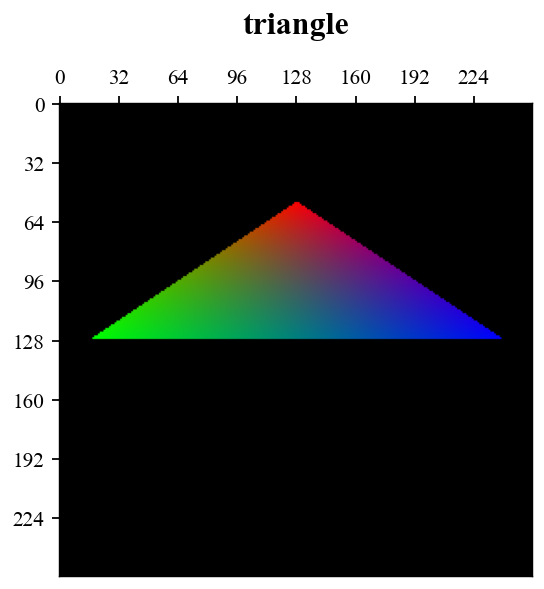

In [9]:
# ÈÄèËßÜÊäïÂΩ±ÂõæÂÉèÊ∏≤Êüì

R = Rasterization(256, 256)
R.setViewM(LookAt(np.array([0, 0, 3]), np.array([0, 0, 0]), np.array([0, 1, 0])))
R.setProjM(Perspective(60))

R.render([t])

show_images(images=[R.get_rgb_img()],
            titles=['triangle'],
            n=1,
            m=1,
            font_scale=1,
            dpi=128)

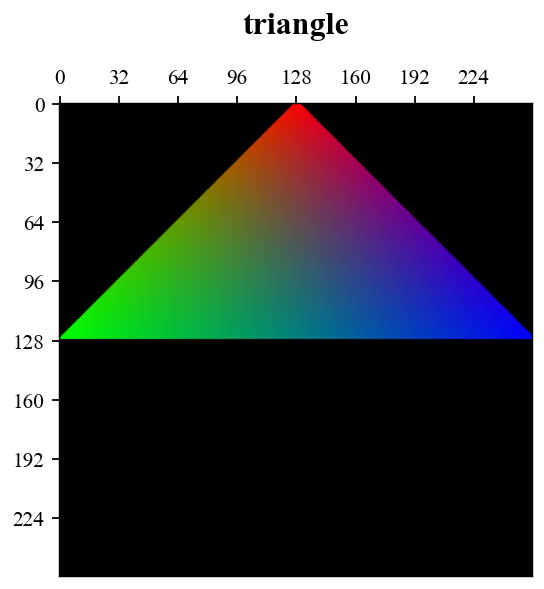

In [10]:
# Ê≠£‰∫§ÊäïÂΩ±ÂõæÂÉèÊ∏≤Êüì

R = Rasterization(256, 256)
R.setViewM(LookAt(np.array([0, 0, 3]), np.array([0, 0, 0]), np.array([0, 1, 0])))
R.setProjM(Ortho(-1, 1, -1, 1, 0.1, 10))

R.render([t])

show_images(images=[R.get_rgb_img()],
            titles=['triangle'],
            n=1,
            m=1,
            font_scale=1,
            dpi=128)

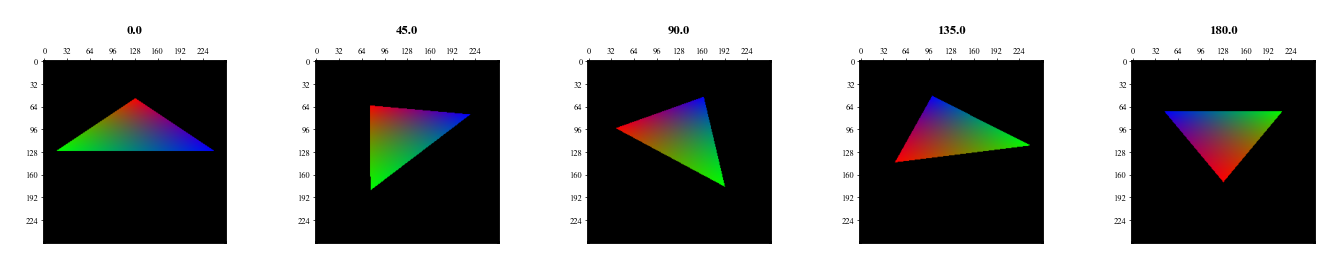

In [11]:
# ‰∏âËßíÂΩ¢ÁªïÂÖ∂Ëá™Ë∫´‰∏≠ÁÇπÊóãËΩ¨ 45,90,135,180 Â∫¶ÂêéÁöÑÈÄèËßÜÊäïÂΩ±ÂõæÂÉè
R = Rasterization(256, 256)
R.setViewM(LookAt(np.array([0, 0, 3]), np.array([0, 0, 0]), np.array([0, 1, 0])))
R.setProjM(Perspective(60))

theta_step = math.pi / 4 # ÊóãËΩ¨Ê≠•Èïø
steps = 4 # ÊóãËΩ¨Ê¨°Êï∞

img = []

R.clear()
R.render([t])
img.append(R.get_rgb_img())
for _ in range(steps):
    R.clear()
    t.rotate_norm(theta_step)
    R.render([t])
    img.append(R.get_rgb_img())

show_images(images=img,
            titles=[f"{(i)*theta_step*180/math.pi:.4}" for i in range(steps+1)],
            n=1,
            m=steps+1,
            font_scale=0.2,
            dpi=256)

### eÈ¢ò

> È¢òÁõÆ

Ê∑±Â∫¶ÊµãËØïÔºöÁªôÂÆö‰∏âËßíÂΩ¢ T1 Âíå T2Ôºå

T1 ‰∏â‰∏™ÁÇπÁöÑÂùêÊ†á‰∏∫[(0,2,0), (-2, 0, 0), (0,0,0)]Ôºå

T2 ‰∏â‰∏™ÁÇπÁöÑÂùêÊ†á‰∏∫[(-0.5,0.5,0.5),(1.5, 0, 0.5),(2.0, 1.0, 0.5)]Ôºå

T1 ‰∏∫Á∫¢Ëâ≤ÔºåT2 ‰∏∫ÁªøËâ≤ÔºåÊ∏≤ÊüìÊó∂ËÄÉËôëÊ∑±Â∫¶ÊµãËØï„ÄÇ

Ê≠§È¢òÈúÄË¶ÅÂÆûÁé∞Ê∑±Â∫¶ÊµãËØïÔºåÂç≥ÂΩì‰∏âËßíÂΩ¢ÁöÑÊüê‰∏™ÂÉèÁ¥†ÁÇπÁöÑÊ∑±Â∫¶Â∞è‰∫éÂ∑≤ÁªèÊ∏≤ÊüìÁöÑÂÉèÁ¥†ÁÇπÁöÑÊ∑±Â∫¶Êó∂Ôºå‰∏çËøõË°åÊ∏≤Êüì„ÄÇ

Ê∑±Â∫¶ÊµãËØï‰∏ªË¶ÅÂÆûÁé∞ÊñπÂºè‰∏∫‰ΩøÁî® z-buffer Â≠òÂÇ®ÂΩìÂâçÂÉèÁ¥†Â∑≤Ê∏≤ÊüìÁöÑÊúÄÊµÖÊ∑±Â∫¶ÔºåÊØèÊ¨°Ê∏≤ÊüìÊó∂ÔºåÂà§Êñ≠ÂΩìÂâçÂÉèÁ¥†ÁöÑÊ∑±Â∫¶ÊòØÂê¶Â∞è‰∫é z-buffer ‰∏≠ÁöÑÊ∑±Â∫¶ÔºàÁ¶ªÈïúÂ§¥ÁöÑË∑ùÁ¶ªÔºâÔºåËã•Á¶ªÈïúÂ§¥Êõ¥ËøëÔºåÂàôËøõË°åÊ∏≤ÊüìÔºåÂπ∂Êõ¥Êñ∞ z-buffer„ÄÇ

ËØ¶ÁªÜÂÆûÁé∞Ê≠•È™§Â∑≤Âú® `Rassterization` Á±ª‰∏≠ÁªôÂá∫ÊèèËø∞„ÄÇ

‰æãÂ¶Ç‰∏ãÊñπÁöÑ‰∏âËßíÂΩ¢Ê∑±Â∫¶Ê∏≤ÊüìÂèØ‰ª•ÁªôÂá∫Ê≠£Á°ÆÁöÑÂâçÂêéÂÖ≥Á≥ªÔºö

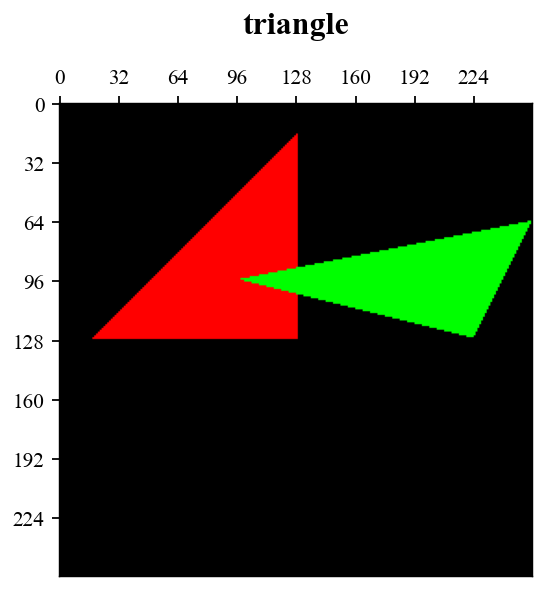

In [12]:
t1 = Triangle()
t1.setVertex(0, 0.0, 2.0, 0.0)
t1.setVertex(1,-2.0, 0.0, 0.0)
t1.setVertex(2, 0.0, 0.0, 0.0)
t1.setColor(0, 1.0, 0.0, 0.0)
t1.setColor(1, 1.0, 0.0, 0.0)
t1.setColor(2, 1.0, 0.0, 0.0)

t2 = Triangle()
t2.setVertex(0,-0.5, 0.5, 0.5)
t2.setVertex(1, 1.5, 0.0, 0.5)
t2.setVertex(2, 2.0, 1.0, 0.5)
t2.setColor(0, 0.0, 1.0, 0.0)
t2.setColor(1, 0.0, 1.0, 0.0)
t2.setColor(2, 0.0, 1.0, 0.0)

R = Rasterization(256, 256)
R.setViewM(LookAt(np.array([0, 0, 4]), np.array([0, 0, 0]), np.array([0, 1, 0])))
R.setProjM(Perspective(60))
R.render([t1,t2])

# Image.fromarray((R.color_buf*255).astype("uint8")).show()#.save('triangle.jpg')
show_images(images=[R.get_rgb_img()],
            titles=['triangle'],
            n=1,
            m=1,
            font_scale=1,
            dpi=128)

Êõ¥Êîπ‰∏âËßíÂΩ¢‰ΩøÂÖ∂‰∏≠‰∏Ä‰∏™‰∏âËßíÂΩ¢Á©øËøáÂè¶‰∏Ä‰∏™‰∏âËßíÂΩ¢Ôºå‰πüËÉΩÊ≠£Á°ÆÊ∏≤ÊüìÂá∫Ê∑±Â∫¶‰ø°ÊÅØÔºö

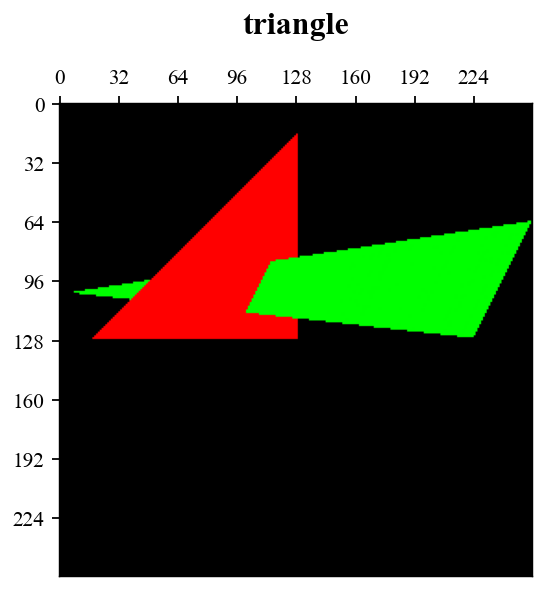

In [13]:
t2 = Triangle()
t2.setVertex(0,-2.5, 0.5, -0.5)
t2.setVertex(1, 1.5, 0.0, 0.5)
t2.setVertex(2, 2.0, 1.0, 0.5)
t2.setColor(0, 0.0, 1.0, 0.0)
t2.setColor(1, 0.0, 1.0, 0.0)
t2.setColor(2, 0.0, 1.0, 0.0)

R.clear()
R.render([t1,t2])

# Image.fromarray((R.color_buf*255).astype("uint8")).show()#.save('triangle.jpg')
show_images(images=[R.get_rgb_img()],
            titles=['triangle'],
            n=1,
            m=1,
            font_scale=1,
            dpi=128)

### f È¢ò

> È¢òÁõÆ

ÊóãËΩ¨ÊèíÂÄºÔºöÁªôÂÆö‰∏âËßíÂΩ¢ TÔºå

ÂàùÂßãÁä∂ÊÄÅÔºàt=0Ôºâ‰∏â‰∏™È°∂ÁÇπÁöÑÂùêÊ†á‰∏∫[(0,0,0),(2,0,0),(1,1,0)], È¢úËâ≤‰∏∫Á∫¢Ëâ≤Ôºå

ÁªàÊ≠¢Áä∂ÊÄÅ(t=1)ÔºåÈ¢úËâ≤‰∏∫ÁªøËâ≤ÔºåÁªïÂùêÊ†áËΩ¥ÂéüÁÇπÊóãËΩ¨‰∫ÜùëÖ = ùëÖùëß(60)ùëÖùë¶(90)ùëÖùë•(60)„ÄÇ

ËØ∑Ê∏≤ÊüìÂá∫ t=0,0.25,0.5,0.75,1 Êó∂ÂàªÁöÑÂõæÂÉèÔºåÊ≥®ÊÑèËøôÈáåÈ¢úËâ≤‰πüÈúÄË¶ÅËøõË°åÊèíÂÄº

Ê≠§È¢ò‰∏ªË¶ÅÈúÄË¶ÅÂÆûÁé∞ÊóãËΩ¨ÊèíÂÄºÔºåÂç≥ÁêÉÈù¢Á∫øÊÄßÊèíÂÄºÔºàSlerpÔºâÔºå‰∏ãÈù¢ÁªôÂá∫ËØ¶ÁªÜÂÆûÁé∞Ê≠•È™§Ôºö

#### SlerpÊèíÂÄº

SlerpÊèíÂÄºÁöÑ‰∏ªË¶ÅËøáÁ®ã‰∏∫Ôºö
- Â∞ÜÊóãËΩ¨Áü©ÈòµËΩ¨Êç¢‰∏∫ÂõõÂÖÉÊï∞Ë°®Á§∫
- ÂØπÂõõÂÖÉÊï∞ËøõË°å Slerp ÊèíÂÄº
  - ËÆ°ÁÆó‰∏§‰∏™ÂõõÂÖÉÊï∞ÁöÑÂ§πËßí
  - ËÆ°ÁÆóÊèíÂÄºÊØî‰æã
  - ÂØπÂ§πËßíËøõË°åÁ∫øÊÄßÊèíÂÄº
- Â∞ÜÊèíÂÄºÂêéÁöÑÂõõÂÖÉÊï∞ËΩ¨Êç¢‰∏∫ÊóãËΩ¨Áü©Èòµ

Êï¥‰∏™ËøáÁ®ãÂèØ‰ª•ÈÄöËøáÁ±ªÊØî‚ÄúÂØπË°®Á§∫Âπ≥Èù¢ÊóãËΩ¨ÁöÑÂ§çÊï∞ËøõË°åÊèíÂÄº‚ÄùÊù•ÁêÜËß£„ÄÇ

‰ª•‰∏ãÁªôÂá∫‰∫ÜÂÆûÁé∞Ê≠•È™§ÔºåÂÖ∂‰∏≠‰ΩøÁî® Scipy Êù•ÂÆûÁé∞ÊóãËΩ¨Áü©Èòµ‰∏éÂõõÂÖÉÊï∞ÁöÑËΩ¨ÂåñÔºåÂπ∂ÁªôÂá∫‰∏§ÁßçÂÆûÁé∞Ôºå‰∏ÄÁßçËá™Ë°åËøõË°åÂõõÂÖÉÊï∞Â§πËßíÁöÑÊèíÂÄºËÆ°ÁÆóÔºå‰∏ÄÁßç‰ΩøÁî® Scipy Êèê‰æõÁöÑ `slerp` ÂáΩÊï∞ËøõË°åÊèíÂÄºËÆ°ÁÆó„ÄÇÂÖ∂ÂÆûÁé∞ÊñπÂºèÂùá‰∏∫‰∏äÈù¢Ê≠•È™§ÁªôÂá∫Ôºå‰ªÖ‰ªÖÊòØÂ∞ÅË£ÖÂêéÊõ¥‰æø‰∫é‰ΩøÁî®„ÄÇ

In [14]:
# SlerpÊèíÂÄº(‰ΩøÁî®ÂõõÂÖÉÊï∞Â§πËßíËøõË°åÊèíÂÄº)
# from scipy.spatial.transform import Rotation
# def slerp(R1, R2, t):
#     # Â∞ÜÊóãËΩ¨Áü©ÈòµËΩ¨Êç¢‰∏∫ÂõõÂÖÉÊï∞
#     quaternion1 = Rotation.from_matrix(R1).as_quat()
#     quaternion2 = Rotation.from_matrix(R2).as_quat()
    
#     # ËÆ°ÁÆó‰∏§‰∏™ÂõõÂÖÉÊï∞‰πãÈó¥ÁöÑÂ§πËßí
#     dot_product = np.dot(quaternion1, quaternion2)
#     theta = np.arccos(np.clip(dot_product, -1.0, 1.0))
    
#     # SLERPÊèíÂÄº
#     sin_theta = np.sin(theta)
#     s1 = np.sin((1.0 - t) * theta) / sin_theta
#     s2 = np.sin(t * theta) / sin_theta
#     interpolated_quaternion = s1 * quaternion1 + s2 * quaternion2
    
#     # Â∞ÜÊèíÂÄºÂæóÂà∞ÁöÑÂõõÂÖÉÊï∞ËΩ¨Êç¢ÂõûÊóãËΩ¨Áü©Èòµ
#     interpolated_rotation = Rotation.from_quat(interpolated_quaternion).as_matrix()
    
#     return interpolated_rotation

# SlerpÊèíÂÄº(‰ΩøÁî®scipy)
from scipy.spatial.transform import Rotation, Slerp
def slerp(R1, R2, key_times):
    # Â∞ÜÊóãËΩ¨Áü©ÈòµËΩ¨Êç¢‰∏∫ÂõõÂÖÉÊï∞
    quaternion1 = Rotation.from_matrix(R1).as_quat()
    quaternion2 = Rotation.from_matrix(R2).as_quat()

    # ÂàõÂª∫ Slerp ÂØπË±°
    slerp_obj = Slerp([0, 1], Rotation.from_quat([quaternion1, quaternion2]))

    # ËøõË°åÊèíÂÄº
    interpolated_rotations = slerp_obj(key_times)

    # Â∞ÜÊèíÂÄºÂæóÂà∞ÁöÑÂõõÂÖÉÊï∞ËΩ¨Êç¢ÂõûÊóãËΩ¨Áü©Èòµ
    interpolated_matrices = [item.as_matrix() for item in interpolated_rotations]

    return interpolated_matrices


# interpolated_matrices

#### LerpÊèíÂÄº

ËøôÈÉ®ÂàÜ‰∏∫ÁÆÄÂçïÁöÑÁ∫øÊÄßÊèíÂÄºÔºåÁî®‰∫éÂØπÈ¢úËâ≤Áõ∏ÂØπ‰∫éÊó∂Èó¥ÁöÑÂèòÂåñËøõË°åÊèíÂÄº

In [15]:
# Lerp
def lerp(c0, c1, key_times):
    return [c0 * (1 - t) + c1 * t for t in key_times]

#### ÊèíÂÄºËÆ°ÁÆó

ÂÄºÂæóÊ≥®ÊÑèÁöÑÊòØÔºåÈ¢òÁõÆÊâÄÁªôÁöÑÊóãËΩ¨Áü©ÈòµÂá∫Áé∞‰∫ÜËØæÂ†ÇÊâÄËÆ≤ÁöÑ Gimbal Lock Áé∞Ë±°Ôºå‰ΩøÂæóÊúÄÁªàÁöÑÊóãËΩ¨‰ªéÁªìÊûú‰∏äË¢´ÈôêÂà∂Âú®‰∫Ü‰∏Ä‰∏™Âπ≥Èù¢ÂÜÖÁöÑÊñπÂêë‰∏äÔºàËøôÈáåÊòØx-zÂπ≥Èù¢Ôºâ

In [16]:
key_times = [0, 0.25, 0.5, 0.75, 1] # ÈúÄË¶ÅÊèíÂÄºÁöÑÂÖ≥ÈîÆÂ∏ßÊó∂Èó¥ÁÇπ

# Ëµ∑Âßã‰∏éÁªàÊ≠¢Áä∂ÊÄÅÊóãËΩ¨Áü©Èòµ
R0 = np.eye(3)
R1 = np.eye(3)
R1 = cv2.Rodrigues(np.array([1, 0, 0]) * math.pi/3)[0] @ R1
R1 = cv2.Rodrigues(np.array([0, 1, 0]) * math.pi/2)[0] @ R1 # ËøôÈáåÂá∫Áé∞‰∫ÜËØæÂ†ÇÊâÄËÆ≤ÁöÑ Gimbal Lock 
R1 = cv2.Rodrigues(np.array([0, 0, 1]) * math.pi/3)[0] @ R1

# Ëµ∑Âßã‰∏éÁªàÊ≠¢Áä∂ÊÄÅÈ¢úËâ≤
C0 = np.array([1, 0, 0])
C1 = np.array([0, 1, 0])

# ËøõË°åÊèíÂÄº
interpolated_matrices = slerp(R0, R1, key_times)
interpolated_colors = lerp(C0, C1, key_times)

#### ÂÖâÊ†ÖÂåñÊ∏≤Êüì

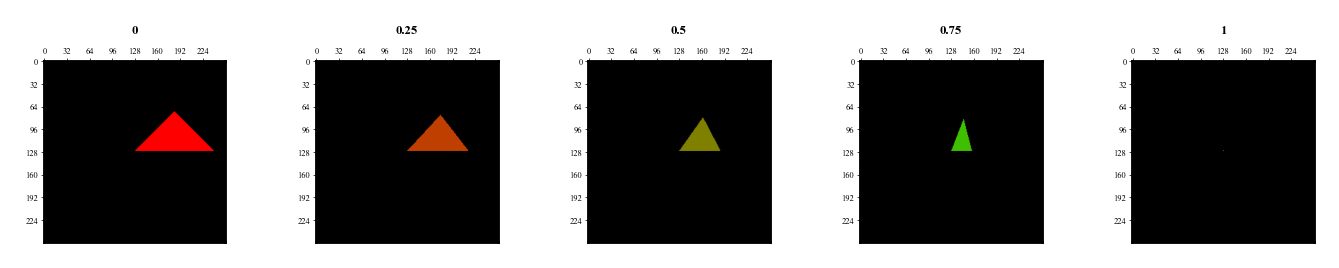

In [17]:
R = Rasterization(256, 256)
R.setViewM(LookAt(np.array([0, 0, 4]), np.array([0, 0, 0]), np.array([0, 1, 0])))
R.setProjM(Perspective(60))
# R.setProjM(Ortho(-2, 2, -2, 2, 0.1, 10))

img = []
for i, (rot_mat, clr) in enumerate(zip(interpolated_matrices, interpolated_colors)):
    t = Triangle()
    t.setVertex(0, 0.0, 0.0, 0.0)
    t.setVertex(1, 2.0, 0.0, 0.0)
    t.setVertex(2, 1.0, 1.0, 0.0)
    t.setColor(0, *clr)
    t.setColor(1, *clr)
    t.setColor(2, *clr)
    t.rotate_mat(rot_mat)

    R.clear()
    R.render([t])
    img.append(R.get_rgb_img())

show_images(images=img,
            titles=key_times,
            n=1,
            m=len(key_times),
            font_scale=0.2,
            dpi=256)